# 3 Method

In [1]:
#!python3 -m pip install -U tensorflow-gpu

# Train custom NN

In [2]:
import numpy as np
background = np.zeros((8,8))
kernel_size = (3,2)
strides = (1,1)

seed = 5

def get_square(background):
    square = np.zeros_like(background)
    square[1:-1,[1,-2]] = 1
    square[[1,-2],1:-1] = 1
    return 0.9*square[..., np.newaxis]

def get_cross(background):
    cross = np.zeros_like(background)
    cross[3:-3,1:-1] = 1
    cross[1:-1,3:-3] = 1
    return 0.9*cross[..., np.newaxis]

training_data = np.asarray([get_square(background), get_cross(background)]).repeat(5_000, axis=0)
np.random.seed(seed)
training_data += np.random.uniform(0, 0.1, size=training_data.shape)
training_labels = np.asarray([1, -1])[..., np.newaxis].repeat(5_000, axis=0)

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

tf.random.set_seed(seed)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, kernel_size=kernel_size, strides=strides, input_shape=[8,8,1], padding='valid', use_bias=True),
    tf.keras.layers.GlobalMaxPooling2D()
])

# Instead of random weights, why not use the 'proposed' weights?
#model.layers[0].set_weights([np.array([ [[[-1]],[[-1]]], [[[1]],[[1]]], [[[-1]],[[-1]]] ]), np.array([-1])])

model.compile(optimizer="sgd", loss="mae")
print(model.summary())

model.fit(training_data, training_labels, batch_size=16, epochs=3, shuffle=True)

2021-12-02 10:02:41.665872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 10:02:41.719229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-02 10:02:41.719640: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2596990000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 7, 1)           7         
_________________________________________________________________
global_max_pooling2d (Global (None, 1)                 0         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.8771
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 0.3066
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0394


### Print the kernel and the bias

[[-0.89865404 -1.3615712 ]
 [ 0.91517675  1.367188  ]
 [-0.90292746 -1.3679376 ]]


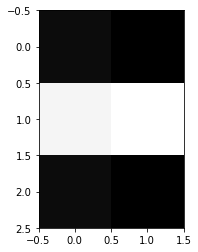

[[-1.0412523]]


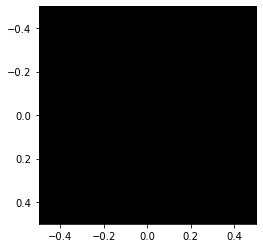

In [3]:
# The kernel could look like one of the expected patches
# Everytime the model is trained, it's not like the one in the paper (more a combination)
from matplotlib import pyplot as plt

weights = np.squeeze(model.layers[0].weights[0].numpy())
print(weights)
plt.imshow(weights, vmin=-1, vmax=1, cmap="gray")
plt.show()

bias = model.layers[0].bias
if not bias is None:
    bias = bias.numpy()[np.newaxis]
    print(bias)
    plt.imshow(bias, vmin=-1, vmax=1, cmap="gray")
    plt.show()

### Some prediction

In [4]:
print(model(get_square(background)[np.newaxis])) # class 1
print(model(get_cross(background)[np.newaxis])) # class -1

tf.Tensor([[1.0128759]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.0213267]], shape=(1, 1), dtype=float32)


### Check 'test set' accuracy

In [5]:
# Test set accuracy is 1.0
test_data = np.asarray([get_square(background), get_cross(background)]).repeat(5_000, axis=0)
np.random.seed(seed)
test_data += np.random.uniform(0, 0.1, size=test_data.shape)
test_labels = np.asarray([1, -1])[...,np.newaxis].repeat(5_000, axis=0)

from sklearn.metrics import classification_report
predictions = model(test_data).numpy().round()
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



# Extract individual unique patches

In [6]:
# from: https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def get_all_unique_patches(cropped_image, kernel_size, strides):
    view_shape = tuple(
        np.subtract(cropped_image.shape, kernel_size) + 1
    ) + kernel_size

    sub_matrices = np.lib.stride_tricks.as_strided(
        cropped_image,
        view_shape,
        cropped_image.strides + cropped_image.strides
    )
    return np.unique(sub_matrices[::strides[0],::strides[1]].reshape((-1,*kernel_size)), axis=0)

square_patches = get_all_unique_patches(get_square(background)[...,0], kernel_size, strides)
cross_patches = get_all_unique_patches(get_cross(background)[...,0], kernel_size, strides)

### Exclusive cross patches

[ 1  2  6  7 10 11 14 18 19 20 21]


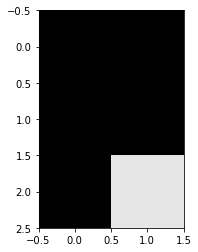

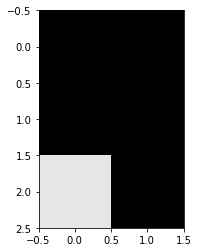

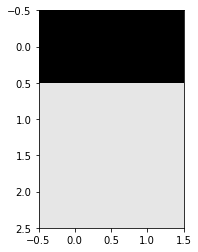

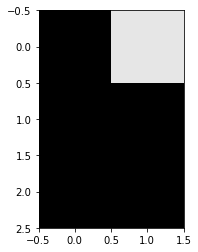

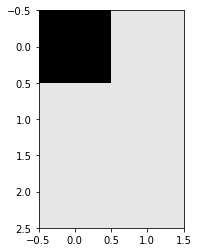

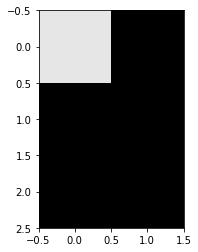

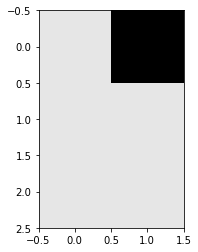

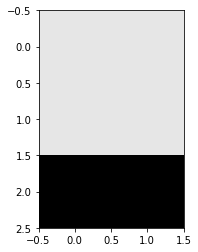

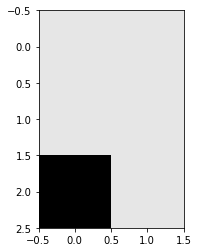

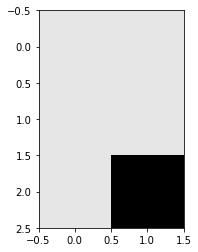

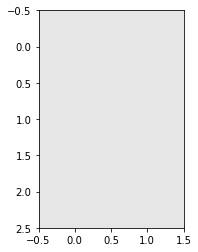

In [7]:
# Patches unique to the cross
cross_indices, = np.where(
    np.asarray([[np.allclose(square_p, cross_p) for square_p in square_patches] for cross_p in cross_patches])
        .mean(axis=1) <= 0
)

print(cross_indices)
for patch in cross_patches[cross_indices]:
    plt.imshow(patch, vmin=0, vmax=1, cmap="gray")
    plt.show()
    #break

### Exclusive cross patches

[ 4  5  6  8 10 12 14]


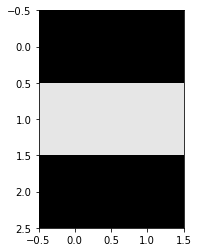

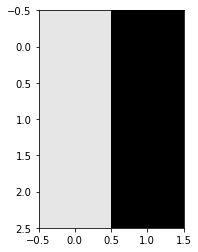

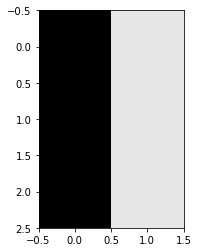

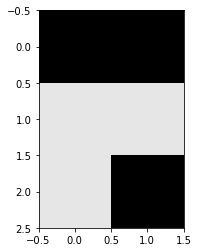

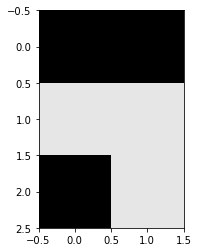

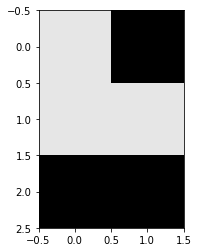

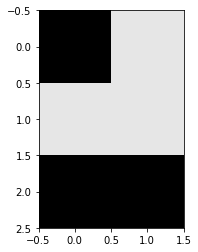

In [8]:
# Patches unique to the square
square_indices, = np.where(
    np.asarray([[np.allclose(cross_p, square_p) for cross_p in cross_patches] for square_p in square_patches])
        .mean(axis=1) <= 0
)

print(square_indices)
square_indices = square_indices[[0,5,3,2,1,6,4]] # reorder in the same way the paper did
for patch in square_patches[square_indices]:
    plt.imshow(patch, vmin=0, vmax=1, cmap="gray")
    plt.show()
    #break

# Trying the evaluation (not simulative) on the square

In [9]:
from sklearn.metrics import r2_score, classification_report
from scipy import stats

# actual NN weights
weights_ = weights
bias_ = bias[0][0]

# NN reduction (only a single convolution) --> No 8x8x1 input image
inference = lambda x: np.sum(weights_.reshape(-1) * x.reshape(-1)) + bias_

#patches = np.concatenate([square_patches[square_indices], cross_patches[cross_indices]])
patches = square_patches[square_indices]

# currently predicting only on every patch once (you could also sample randomly multiple times with added noise)
sample_idx = np.random.randint(0,patches.shape[0], 50)
samples = []
predictions = []
classes = []
for idx, patch in enumerate(patches[sample_idx]):
    noise = np.random.uniform(0, 0.1, size=patch.shape)
    samples += [sample_idx[idx]]
    predictions += [inference(patch + noise)]
    classes += [1 if sample_idx[idx] < square_patches[square_indices].shape[0] else -1]

samples = np.asarray(samples).astype(float)[:,np.newaxis]
predictions = np.asarray(predictions).astype(float)[:,np.newaxis]
classes = np.asarray(classes).astype(float)[:,np.newaxis]

In [10]:
from scipy.stats import ttest_ind
import numpy as np

for idx, patch in enumerate(patches[:square_indices.shape[0]]):
    
    # prediction for the samples with the same id (could be used for larger simulative metrics)
    identifier = np.asarray(sample_idx==idx)
    non_identifier = np.asarray(sample_idx!=idx)
    
    is_pattern_sample = np.array(samples)
    is_pattern_sample[identifier] = 1
    is_pattern_sample[non_identifier] = -1

    #classes_ = np.array(classes)
    #classes_[identifier] = 1
    #classes_[non_identifier] = -1

    class_predictions = np.array(predictions)
    
    ttest, pval = ttest_ind(class_predictions[is_pattern_sample==1], class_predictions[is_pattern_sample==-1])
    print(f"{ttest:.02f} : {pval:.02f}")

    #print(classification_report(labels, predictions))
    #print(r2_score(labels, predictions))
    #print(stats.pearsonr(labels, predictions))
    #print()

3.77 : 0.00
-3.97 : 0.00
-6.88 : 0.00
2.48 : 0.02
0.57 : 0.57
1.85 : 0.07
0.68 : 0.50


# Open questions:
* Table 1: "The light spots have value one and the dark spots have value minus one." vs page 5 "The dark pixels have a value of 0.0, and the light pixels have a value of 0.9 [...]"
* Their proposed pattern is stable, but arriving at the exact mentioned pattern is nearly impossible (weights are almost always a combination of the distinct patterns)
* Any formular for that "[...] significance of a partial correlation test as a measure for [...]"?
* Any formular for that "[...] coefficient of determination between the feature X and the prediction P."?